# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [1]:
import math
import re

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [4]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [5]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [6]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [6]:
#Eliminamos los valores nulos+
print('----Valores nulos---')
print(df_reviews.loc[:,['average_rating','votes']].isnull().sum())
print('----Valores nulos-despues----')
df_reviews=df_reviews.dropna().copy()
print(df_reviews.loc[:,['average_rating','votes']].isnull().sum())

----Valores nulos---
average_rating    2
votes             2
dtype: int64
----Valores nulos-despues----
average_rating    0
votes             0
dtype: int64


In [7]:
#Duplicados
print(f'tenemos {df_reviews.duplicated().sum()} duplicados')

tenemos 0 duplicados


In [8]:
#Desbalance de clases
print(df_reviews['pos'].value_counts())
#Existe equilibrio en las clases

0    23715
1    23614
Name: pos, dtype: int64


## EDA

Veamos el número de películas y reseñas a lo largo de los años.

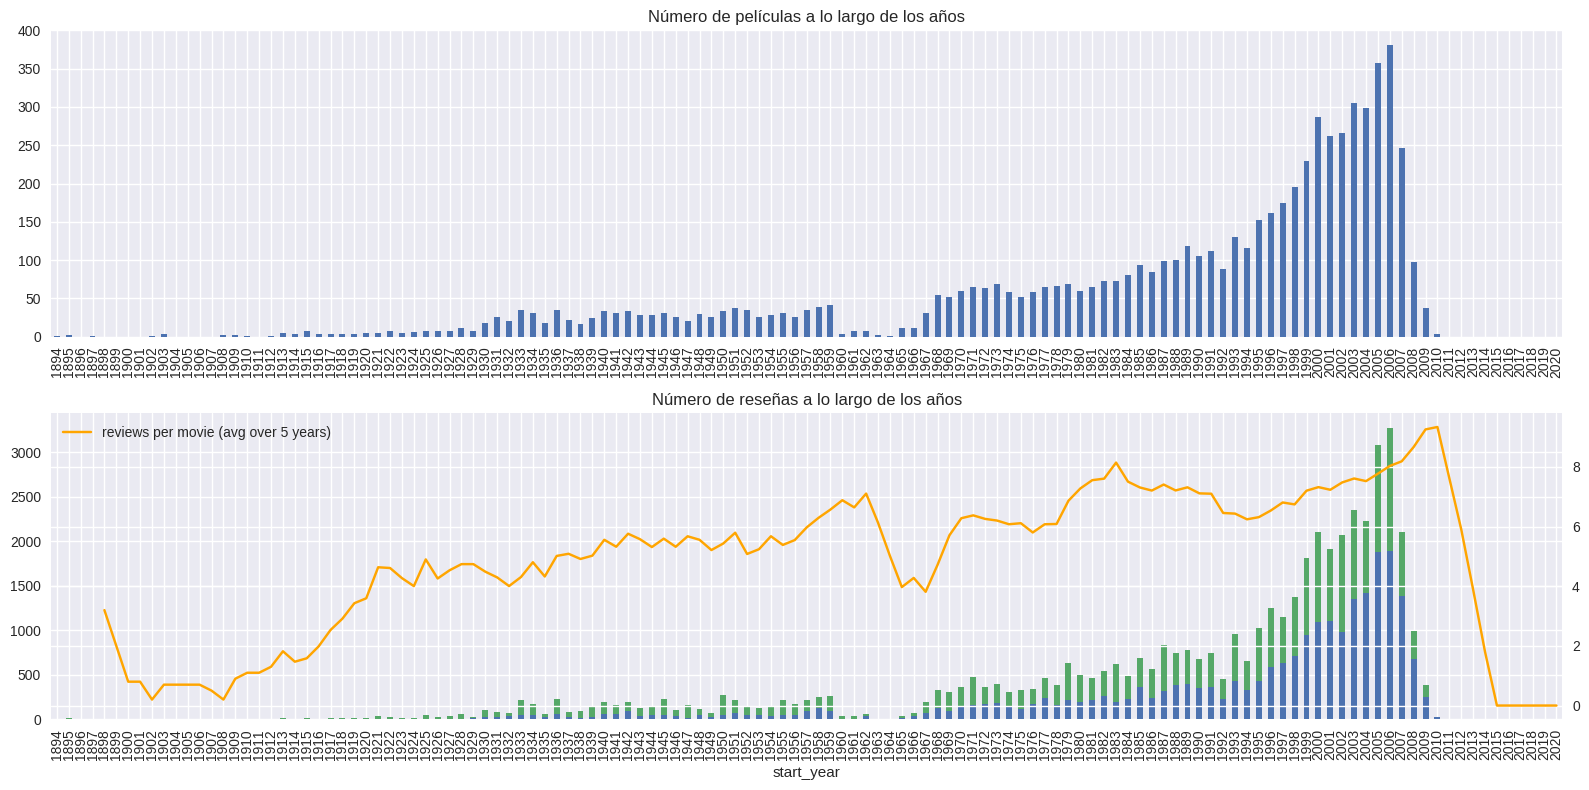

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)
dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)
lines, labels = axt.get_legend_handles_labels()

ax.legend(lines, labels, loc='upper left')
ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

- Podemos notar que el número de peliculas aumenta a medida que pasan los años, sin embargo el numero de reseñas por pelicula se mantiene relativamente igual. Esto puede indicar varias cosas, entre ellas que lo que ha aumentado no son los escritores de las reseñas sino el numero de peliculas comentadas.

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

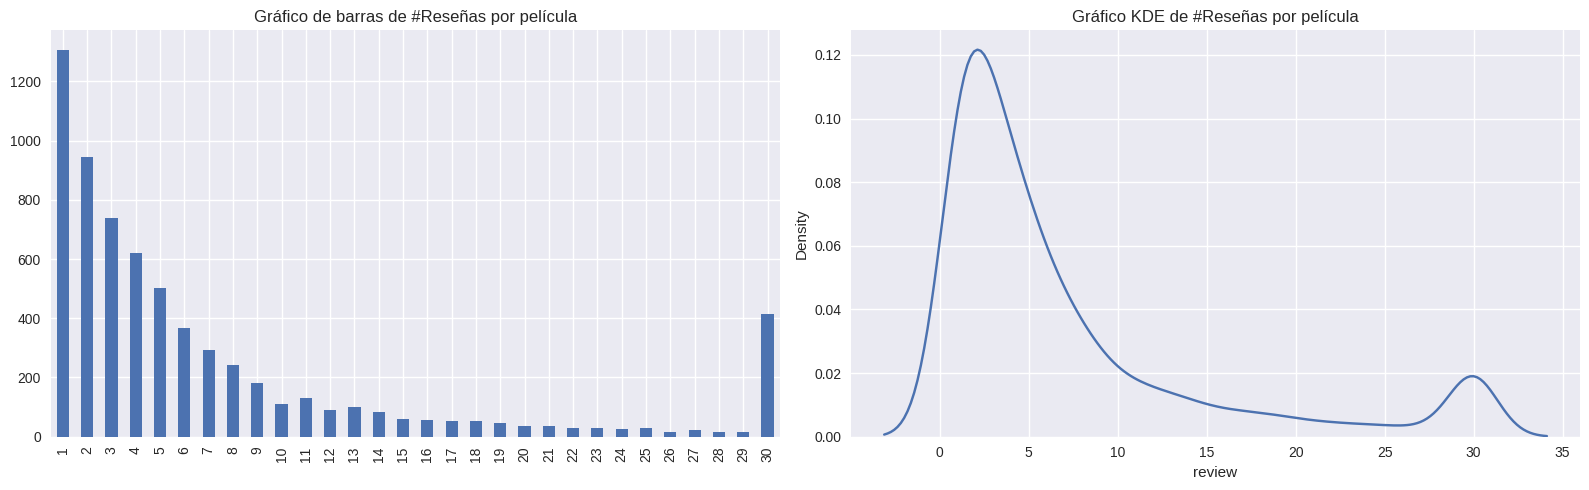

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

Podemos notar que el numero de reseñas generalmente es 1 por peliculas, sin embargo, tambien tenemos peliculas donde el numero de reseñas es 30 (cerca de 400 peliculas). Este ccomportamiento resulta un poco estraño por el cambio brusco en el numero de peliculas.

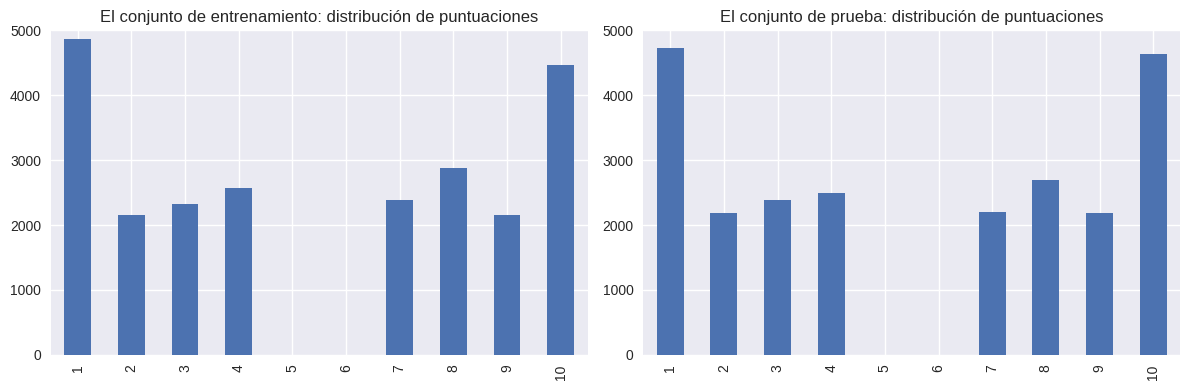

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Como podemos observar, las puntuaciones de los usuarios son extremas, es decir, o les encantó o no les gustó. Esto podría indicar que los evaluadores son aficionados al tema y que las puntuaciones no reflejan con precisión el valor de la película.

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

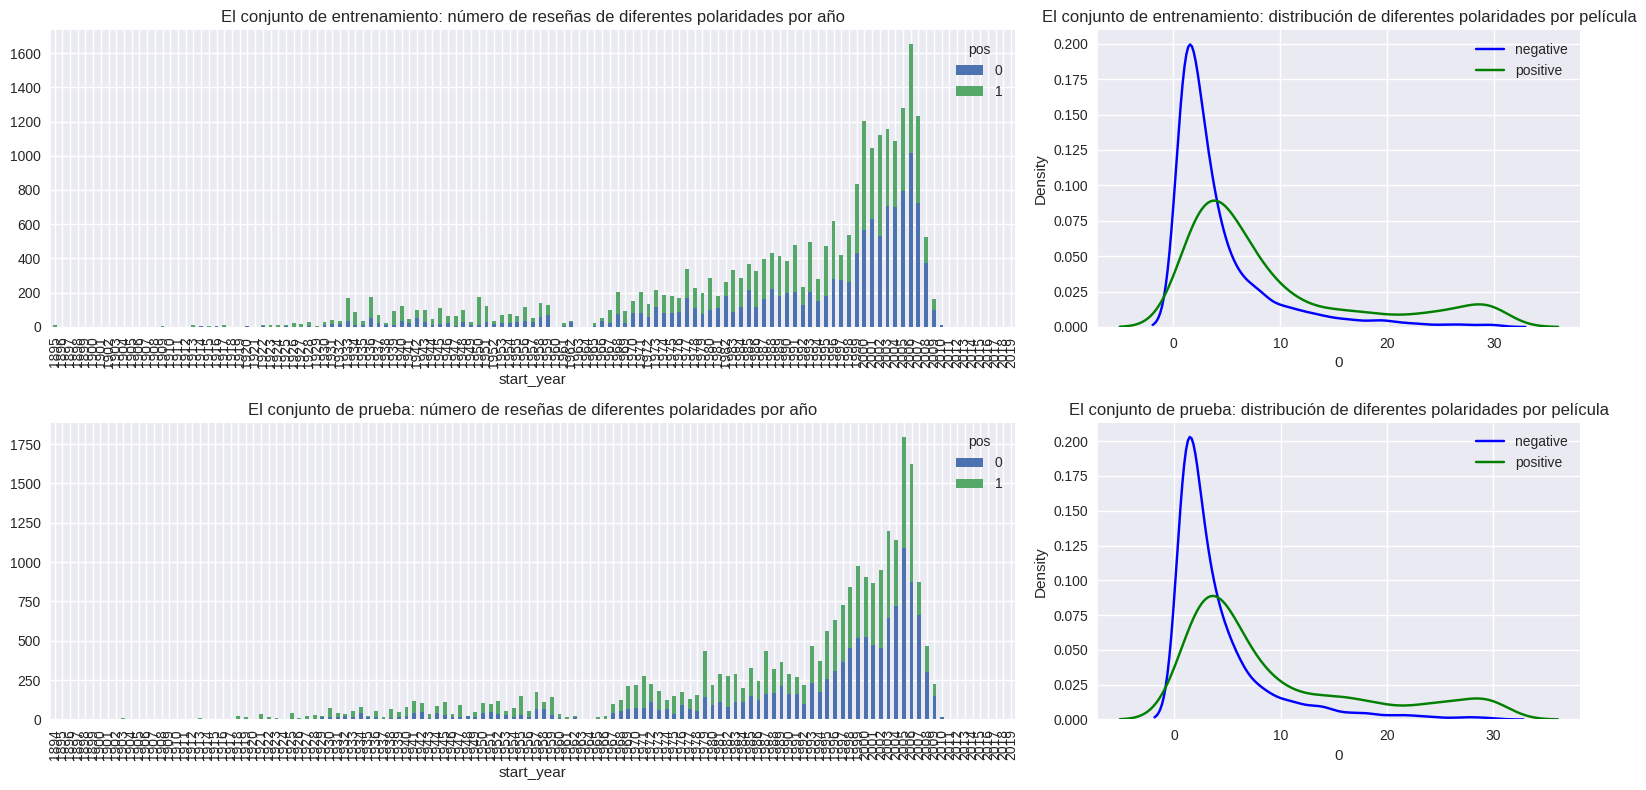

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

Como observamos anteriormente, las calificaciones están equilibradas, es decir, existe una cantidad similar de reseñas positivas y negativas. Sin embargo, el gráfico KDE de la derecha nos muestra que las reseñas positivas prevalecen cuando la película ha recibido muchos comentarios, mientras que las reseñas negativas dominan cuando el número de comentarios es inferior a 10. Esto podría indicar que la escasez de reseñas en sí misma puede ser un factor que contribuye a que las películas tengan pocas reseñas. Un ejemplo contrario a esta tendencia sería una película muy recomendada y famosa, pero que en realidad resulta ser de mala calidad y, por lo tanto, acumula muchas reseñas negativas.

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [10]:
import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [11]:
#Así se ve una reseña del conjunto de datos
print(df_reviews['review'].iloc[0])
#Para normalizar el texto vamos a hacer lo sigueinte
#- Tranformar el texto a minusculas
#- Solo nos quedaremos con letras
#- Tokenizamos el texto
#- Lematizamos el texto
def normalizar_texto(texto):
    #minusculas
    texto_final=texto.lower()
    #solo letras
    texto_final=re.sub(r'[^a-z \']','',texto_final)#Solo permitimos letras, espcios y apostrofes para las contacciones
    #se deberían reemplazar las contracciones, pero las dejaremos.
    #Tokenizamos y lematizamos (Este paso lo dejamos para pasos futuros)
    
    
    
    return texto_final

df_reviews['review_norm'] = df_reviews['review'].apply(lambda x: normalizar_texto(x))

print()
print(df_reviews['review_norm'].iloc[0])

The pakage implies that Warren Beatty and Goldie Hawn are pulling off a huge bank robbery, but that's not what I got out of it! I didn't get anything! In the first half there's a new character (without introduction) in every other scene. The first half-hour is completely incomprehensible, the rest is just one long, annoying, underlit chase scene. There's always an irritating sound in the background whether it's a loud watch ticking, a blaring siren, a train whistling, or even the horrible score by Quincy Jones. There are a lot of parts that are laughably bad, too. Like, the bad guys chasing Beatty on thin ice with a CAR! Or, the police arriving at the scene roughly fifteen times. I really hated this movie!

the pakage implies that warren beatty and goldie hawn are pulling off a huge bank robbery but that's not what i got out of it i didn't get anything in the first half there's a new character without introduction in every other scene the first halfhour is completely incomprehensible t

## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [12]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy().iloc[0:10000]
df_reviews_test = df_reviews.query('ds_part == "test"').copy().iloc[0:10000]

train_target = df_reviews_train['pos'].iloc[0:10000]
test_target = df_reviews_test['pos'].iloc[0:10000]
print(df_reviews_train.shape)
print(df_reviews_test.shape)

(10000, 18)
(10000, 18)


## Trabajar con modelos

### Modelo 1 - Constante

In [13]:
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer

In [14]:
corpus_train=[n['review_norm'] for _,n in df_reviews_train.iterrows()]
corpus_test=[n['review_norm'] for _,n in df_reviews_test.iterrows()]

In [15]:
count_vect = CountVectorizer()
bow_train = count_vect.fit_transform(corpus_train)
bow_test=count_vect.transform(corpus_test)
print(bow_train.shape)

(10000, 61120)


          train  test
Accuracy   0.49  0.48
F1         0.66  0.64
APS        0.49  0.48
ROC AUC    0.50  0.50


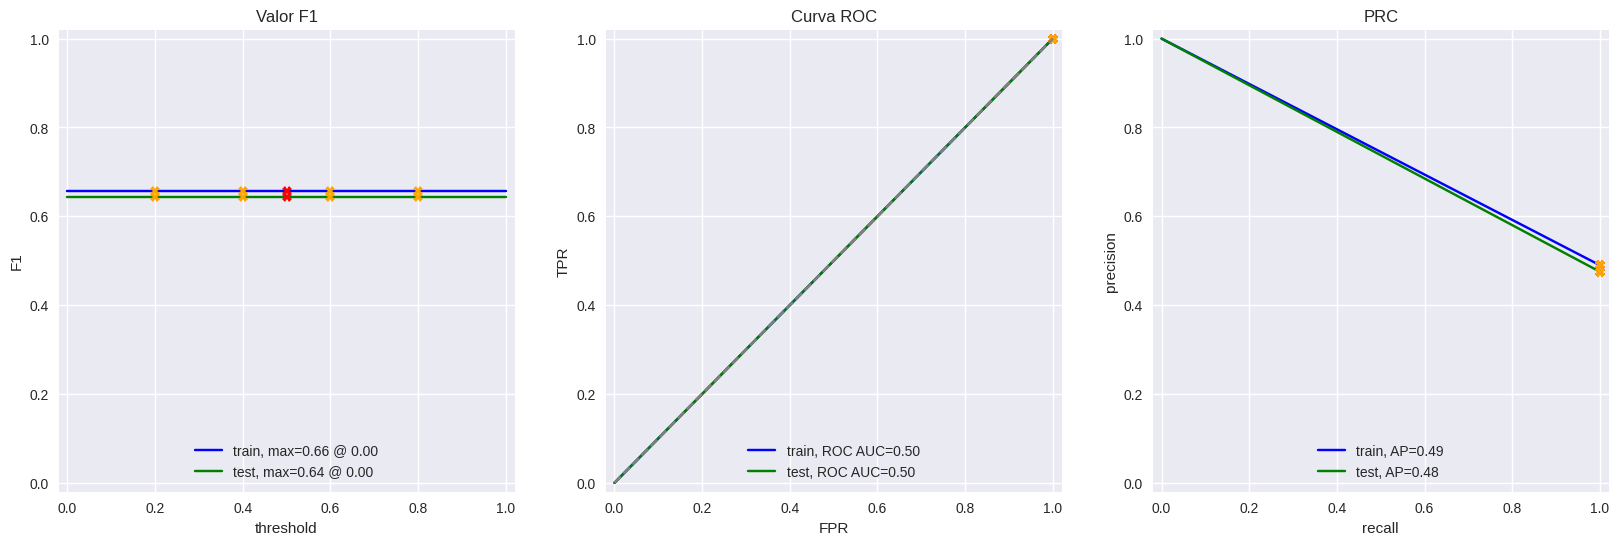

In [16]:
model0=DummyClassifier(strategy="constant",constant=1)
model0.fit(bow_train,train_target)
evaluate_model(model0, bow_train, train_target, bow_test, test_target)


### Modelo 2 - NLTK, TF-IDF y LR

TF-IDF

In [17]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [23]:
def text_preprocessing_2(text):
    
    lemmatizer = nltk.stem.WordNetLemmatizer()
    tokens = nltk.tokenize.word_tokenize(text.lower())
    
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    
    return ' '.join(lemmas)

In [24]:
corpus_train=[text_preprocessing_2(n['review_norm']) for _,n in df_reviews_train.iterrows()]
corpus_test=[text_preprocessing_2(n['review_norm']) for _,n in df_reviews_test.iterrows()]

In [27]:
stop_words = set(stopwords.words('english'))
tfidf_vectorizer_2 = TfidfVectorizer(stop_words=stop_words)
tf_idf_train = tfidf_vectorizer_2.fit_transform(corpus_train)
tf_idf_test = tfidf_vectorizer_2.transform(corpus_test)

          train  test
Accuracy   0.95  0.87
F1         0.95  0.86
APS        0.99  0.93
ROC AUC    0.99  0.94


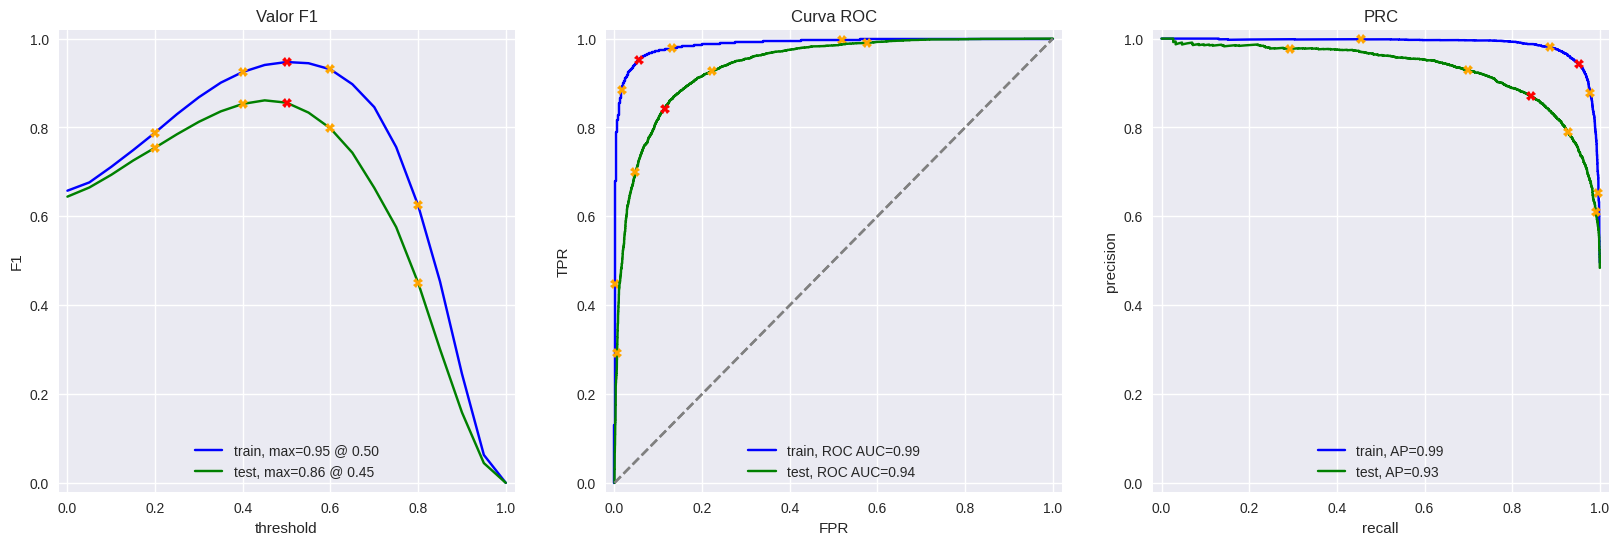

In [29]:
model_2=LogisticRegression()
model_2.fit(tf_idf_train,train_target)
evaluate_model(model_2, tf_idf_train, train_target, tf_idf_test, test_target)

### Modelo 3 - spaCy, TF-IDF y LR

In [30]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

* Utilziaremos un corpus con el texto tokenizado y lematizado

In [31]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [32]:
corpus_train=[text_preprocessing_3(n['review_norm']) for _,n in df_reviews_train.iterrows()]
corpus_test=[text_preprocessing_3(n['review_norm']) for _,n in df_reviews_test.iterrows()]

In [33]:
tfidf_vectorizer_3 = TfidfVectorizer(stop_words=stop_words)
bow_train=tfidf_vectorizer_3.fit_transform(corpus_train)
bow_test=tfidf_vectorizer_3.transform(corpus_test)

          train  test
Accuracy   0.94  0.87
F1         0.94  0.86
APS        0.99  0.93
ROC AUC    0.99  0.94


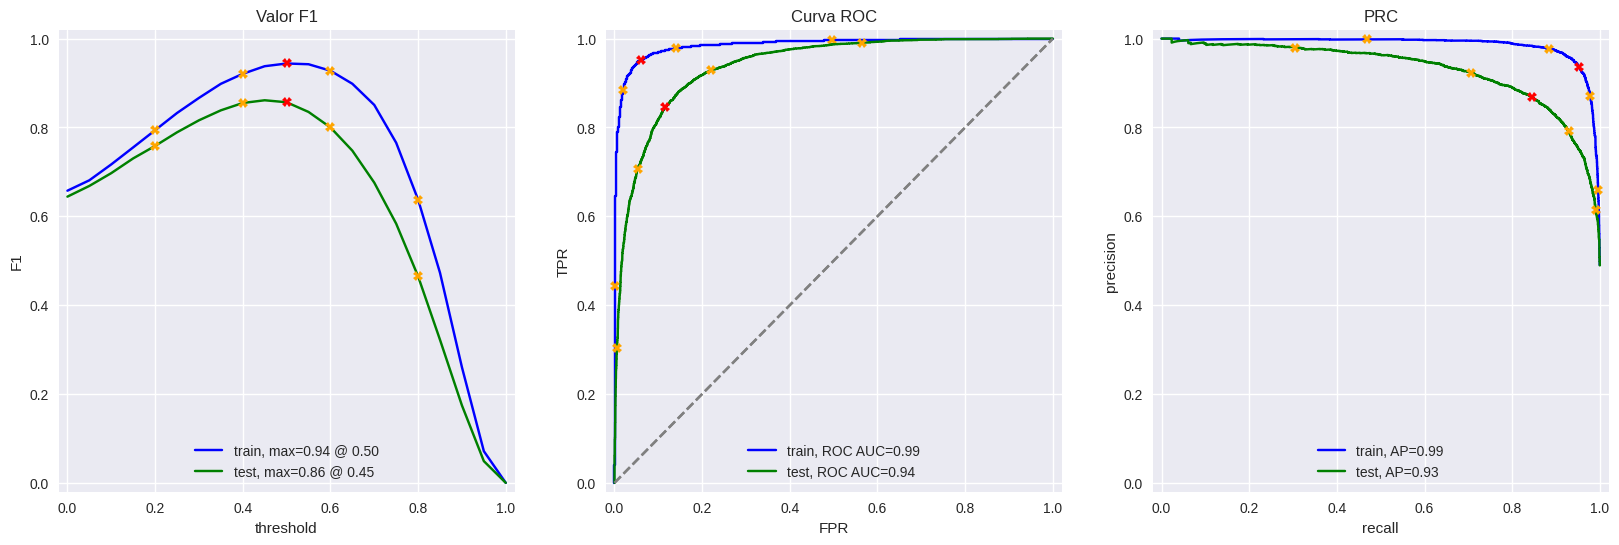

In [34]:
model_3=LogisticRegression()
model_3.fit(bow_train,train_target)
evaluate_model(model_3, bow_train, train_target, bow_test, test_target)

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

In [35]:
from lightgbm import LGBMClassifier
import lightgbm as lgb

In [36]:
# Definir el callback de registro
callbacks = [lgb.log_evaluation(100)]
model_4 = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.1,
    objective='binary',
    random_state=42)

In [37]:
model_4.fit(bow_train, train_target, eval_set=[(bow_test, test_target)], callbacks=callbacks)

[100]	valid_0's binary_logloss: 0.346728
[200]	valid_0's binary_logloss: 0.331121
[300]	valid_0's binary_logloss: 0.332764
[400]	valid_0's binary_logloss: 0.342903
[500]	valid_0's binary_logloss: 0.356481


LGBMClassifier(n_estimators=500, objective='binary', random_state=42)

          train  test
Accuracy    1.0  0.85
F1          1.0  0.85
APS         1.0  0.92
ROC AUC     1.0  0.93


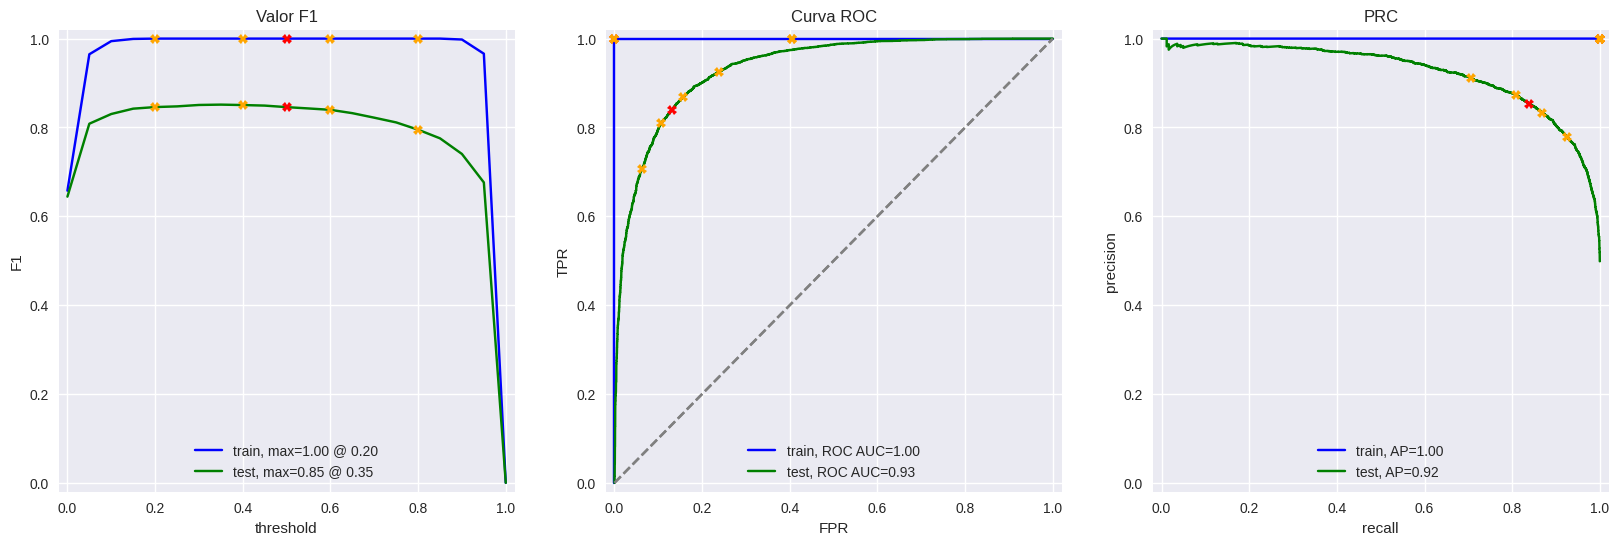

In [38]:
evaluate_model(model_4, bow_train, train_target, bow_test, test_target)

###  Modelo 9 - BERT

In [43]:
import torch
import transformers

In [44]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy().iloc[0:50]
df_reviews_test = df_reviews.query('ds_part == "test"').copy().iloc[0:50]

train_target = df_reviews_train['pos'].iloc[0:50]
test_target = df_reviews_test['pos'].iloc[0:50]
print(df_reviews_train.shape)
print(df_reviews_test.shape)

(50, 18)
(50, 18)


In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [ ]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # texto al id de relleno de tokens junto con sus máscaras de atención 
       
    # <escribe tu código aquí para crear ids_list y attention_mask_list>
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Uso del dispositivo {device}.')
    
    # obtener insertados en lotes
    
    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # <escribe tu código aquí para crear attention_mask_batch
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [ ]:
# ¡Atención! La ejecución de BERT para miles de textos puede llevar mucho tiempo en la CPU, al menos varias horas
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

In [ ]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

## Mis reseñas

In [39]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',    
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

my_reviews['review_norm'] = my_reviews['review'].apply(lambda x: normalizar_texto(x))

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn't expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i reall...


### Modelo 2

In [40]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.24:  i did not simply like it not my kind of movie
0.24:  well i was bored and felt asleep in the middle of the movie
0.52:  i was really fascinated with the movie
0.25:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.49:  i didn't expect the reboot to be so good writers really cared about the source material
0.28:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.12:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.87:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Modelo 3

In [41]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.28:  i did not simply like it not my kind of movie
0.19:  well i was bored and felt asleep in the middle of the movie
0.48:  i was really fascinated with the movie
0.13:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.38:  i didn't expect the reboot to be so good writers really cared about the source material
0.41:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.10:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.89:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Modelo 4

In [42]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.50:  i did not simply like it not my kind of movie
0.29:  well i was bored and felt asleep in the middle of the movie
0.51:  i was really fascinated with the movie
0.09:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.59:  i didn't expect the reboot to be so good writers really cared about the source material
0.40:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.14:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
1.00:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Modelo 9

In [ ]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

## Conclusiones

**Se probaron 3 modelos:**
- **DummyClassifier**
    - Se encontró que el resto de modelos utilizados superan en metricas con gran diferencia a nuestro modelo Dummy, lo que quiere decir que los datos representan bien el problema que queremos solucionar.
- **LogisticRegression**
    - La curva ROC para los datos de entrenamiento se muestra casi perfecta, con un valor AUC de 0.99, mientras que para los datos de prueba se obtiene un valor 0.86. Esto indica que el modelo esta bien entrenado.
- **LGBMClassifier**
    - Muestra resultados similares al modelo 'LogisticRegression', en terminos generales el modelo consiguió un valor F1 de 0.85

**Para la normalización del texto se utilizó**
- **TfidfVectorizer (usando stopwords)**
    - La tokenización y el lematizado usando stopword fue relativamente rapido comparado al uso de SpaCy.
- **SpaCy**
    - El tiempo que tardó en tokenizar los datos (nlp) y el tiempo que tomó en lematizar cada observación del dataframe, fue muy alta para 10 mil observaciones.
- **CountVectorizer**
    - Este fue el metodo mas rápido ya que solo se requiere tokenización, sin embargo no se lematizó el texto, este metodo se utilizó para nuestra prueba de cordura
- **insertados con BERT no fue utilizado por el tiempo que requiere el entrenamiento**
